# Intro

In [1]:
import os
import os.path as op

import numpy as np
import scipy as sp
import pandas as pd
import sqlalchemy as sa
import numba

from IPython.display import display, HTML
import matplotlib.pyplot as plt

import qgrid
qgrid.nbinstall(overwrite=True)
qgrid.set_defaults(remote_js=True, precision=4)

from common import dat

/home/kimlab1/strokach/anaconda3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
import seaborn as sns
sns.set_context('notebook', font_scale=2)

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Functions

In [204]:
def matrix_to_values(df):
    """
    Convert a dataframe produced by `.corr()` to (name_1, name_2, value) format.
    """
    df.sort_index(axis=0, inplace=True)
    df.sort_index(axis=1, inplace=True)
    idx = np.triu_indices_from(df.values, 1)
    df_2 = pd.DataFrame({
        'name_1': df.index[idx[0]],
        'name_2': df.columns[idx[1]],
        'value': df.values[idx]})
    assert all(df_2['name_1'] < df_2['name_2'])
    return df_2

# Cell tissue similarity

In [5]:
cell_info = (
    pd.read_csv('challenge_data/sanger_molecular_data/cell_info.csv/cell_info.csv', sep=',')
)

In [6]:
cell_info.head()

,Sanger.Name,CCLE.Name,Alternative.Name,Disease.Area,Tissue..General.,COSMIC
0,22RV1,22RV1_PROSTATE,22RV1,Urology,male genital system,924100
1,647-V,647V_URINARY_TRACT,647V,Urology,urinary tract,906797
2,A549,A549_LUNG,A549,Lung,lung,905949
3,BFTC-905,BFTC905_URINARY_TRACT,BFTC905,Urology,urinary tract,910926
4,BT-20,BT20_BREAST,BT20,Breast,breast,906801


# Same cell tissue

In [7]:
cell_info.sort_values('Sanger.Name', inplace=True)

In [8]:
cell_tissue_similarity = []
for i, (cell_name_1, cell_tissue_1) in enumerate(cell_info[['Sanger.Name', 'Tissue..General.']].values):
    for cell_name_2, cell_tissue_2 in cell_info[i + 1:][['Sanger.Name', 'Tissue..General.']].values:
        row = (cell_name_1, cell_name_2, int(cell_tissue_1 == cell_tissue_2),)
        cell_tissue_similarity.append(row)
cell_tissue_similarity_df = pd.DataFrame(cell_tissue_similarity, columns=['cell_1', 'cell_2', 'same_cell_tissue'])

In [9]:
assert all(cell_tissue_similarity_df['cell_1'] < cell_tissue_similarity_df['cell_2'])

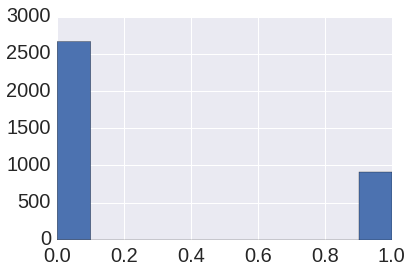

In [10]:
cell_tissue_similarity_df['same_cell_tissue'].hist()

In [11]:
cell_tissue_similarity_df.head()

,cell_1,cell_2,same_cell_tissue
0,22RV1,647-V,0
1,22RV1,A549,0
2,22RV1,BFTC-905,0
3,22RV1,BT-20,0
4,22RV1,BT-474,0


In [12]:
cell_tissue_similarity_df.shape

(3570, 3)

In [13]:
85 * 84 // 2  # all cell lines

3570

In [14]:
engine = sa.create_engine('mysql://strokach:@192.168.6.19:3306/az_dream_cell_features')
cell_tissue_similarity_df.to_sql('same_cell_tissue', engine, if_exists='replace')
engine.execute('create index a on same_cell_tissue (cell_1(255), cell_2(255))')
engine.execute('create index b on same_cell_tissue (cell_2(255), cell_1(255))')

# Gene expression

In [15]:
gex = (
    pd.read_csv('challenge_data/sanger_molecular_data/gex.csv/gex.csv', sep=',', index_col=0)
)
gex.sort_index(axis=0, inplace=True)
gex.sort_index(axis=1, inplace=True)

In [16]:
display(gex.head())
print(gex.shape)

,22RV1,647-V,A549,BFTC-905,BT-20,BT-474,BT-549,C32,CAL-120,CAL-148,CAL-51,CAMA-1,COLO-205,Calu-3,Calu-6,DMS-114,DU-4475,EVSA-T,HCC1143,HCC1187,HCC1395,HCC1419,HCC1428,HCC1500,HCC1569,HCC1806,HCC1937,HCC1954,HCC38,HCC70,HCT-116,HT-1197,HT-1376,HT-29,Hs-578-T,J82,KATOIII,KMS-11,KU-19-19,LS-513,M14,MCF7,MDA-MB-157,MDA-MB-231,MDA-MB-361,MDA-MB-415,MDA-MB-436,MDA-MB-453,MDA-MB-468,MFM-223,NCI-H1299,NCI-H1563,NCI-H1703,NCI-H1793,NCI-H1975,NCI-H2085,NCI-H2170,NCI-H2228,NCI-H226,NCI-H2291,NCI-H23,NCI-H3122,NCI-H358,NCI-H520,NCI-H522,NCI-H747,NCI-H838,NCI-SNU-16,RKO,RT4,SW48,SW620,SW780,SW837,SW900,SW948,T-24,T47D,TCCSUP,UACC-812,UM-UC-3,VCaP,VM-CUB-1
A1BG,3.530584,2.788878,5.351535,3.654691,3.413191,3.512673,5.503611,5.301429,6.208447,3.967330,5.506955,5.473663,3.659052,3.445720,3.250152,5.025810,3.712974,3.992799,6.653324,3.860001,3.818815,5.062066,4.943208,5.117451,4.651759,7.557265,4.012750,4.394033,4.314272,3.558035,3.231159,2.891782,2.996703,3.333250,5.696576,3.403658,3.765339,3.429940,4.146027,3.436224,4.331010,4.677871,5.633269,3.993322,3.239070,3.160667,5.675360,5.622213,3.251473,5.366995,4.410914,3.784122,5.742016,5.217647,4.617750,5.740719,3.213566,3.538686,3.534607,3.612600,3.906863,3.219004,3.779601,4.238043,4.313296,3.149603,4.420252,3.367825,2.733173,3.359233,3.604357,3.226869,3.085338,3.193601,3.562164,3.120944,3.030891,4.015417,3.386465,4.565087,4.806826,3.442403,3.233975
A1CF,6.364383,2.929860,5.899714,2.879513,2.960482,3.054495,3.107128,3.126334,2.981775,3.075956,2.872071,3.141034,7.210961,2.976691,3.359157,2.947547,2.932662,2.872890,2.809667,2.977178,2.972840,2.985650,2.949033,2.894628,2.962179,2.954737,2.815736,2.913561,2.984274,2.991716,2.957640,3.134189,2.931337,3.035997,2.885962,2.948641,2.972890,3.003220,3.076125,4.307525,2.903783,3.221482,3.235645,2.906964,2.973523,3.065818,2.934078,2.920719,2.909005,2.999021,3.057679,3.178817,3.016101,3.123458,2.994303,2.807124,2.962080,2.965398,2.904675,3.251876,3.131992,2.949988,2.931010,3.123205,3.109252,3.030174,2.933147,7.616778,3.176171,3.076448,3.049307,3.756048,2.833101,3.103560,2.996603,6.035482,3.190048,3.013487,3.177574,2.979775,3.159821,4.049642,3.038010
A2M,5.333116,3.163920,3.385313,3.145660,3.485672,3.374128,3.306887,11.194502,3.133883,3.252529,3.287678,3.553870,3.284050,3.125750,3.392565,3.335711,5.857938,3.371901,3.181255,3.101857,7.333633,3.529651,3.716710,3.443310,12.962624,3.102288,3.262667,3.431608,3.515306,3.548095,3.015057,3.274353,3.390316,3.433933,3.184189,4.248470,3.347285,3.531883,3.692506,3.914816,6.572986,3.502539,4.031836,3.280705,3.496711,3.194349,3.353889,3.585621,6.748265,5.349334,3.481793,3.520293,3.364239,3.264536,3.315750,3.352053,3.425817,3.317356,3.542737,3.271784,3.454828,3.257612,3.189635,3.322089,3.702488,3.320323,3.280496,3.234721,3.587857,3.414311,3.370937,3.423342,3.485978,3.328670,3.253735,3.424149,3.422091,3.435566,10.367402,4.068013,3.318134,3.669509,3.262412
A2ML1,2.907726,2.659589,2.876303,2.618580,3.203183,2.990600,2.750999,2.809603,2.652527,4.176452,3.946546,3.037501,2.830605,2.814887,3.217121,2.734617,2.810957,3.244767,2.882418,2.827790,3.094473,2.970912,3.219312,2.862272,2.984883,2.912465,3.026253,2.914855,2.912427,5.398271,2.747944,3.203564,2.863508,2.872562,2.850983,2.866479,2.935965,2.757120,3.052064,2.872895,2.756976,2.823238,2.994586,2.784113,2.957074,2.861270,2.845468,2.970381,3.038762,2.917099,2.868770,2.816616,2.961184,2.966420,2.875874,3.078362,3.027520,2.722523,2.815796,2.768303,2.855416,2.868177,2.907705,2.753796,2.896764,2.900725,2.714300,3.038924,2.735681,2.920353,3.211124,2.975449,2.791813,2.970275,2.844126,2.810739,3.005388,2.927293,2.841073,2.799085,2.848456,3.045514,2.848073
A3GALT2P,2.815383,2.949402,2.794812,3.051636,2.727538,3.046176,2.600750,2.772945,2.759164,2.973257,3.007847,2.813239,2.817318,2.906216,2.951504,2.867167,3.222096,2.758084,2.898673,2.949275,3.002633,3.039915,2.889149,2.794062,2.696788,2.841877,2.637763,2.627251,2.638571,2.585234,3.350766,2.676877,2.928732,2.911099,2.860962,2.682130,2.642

(17419, 83)


In [17]:
gex.isnull().any().any()

False

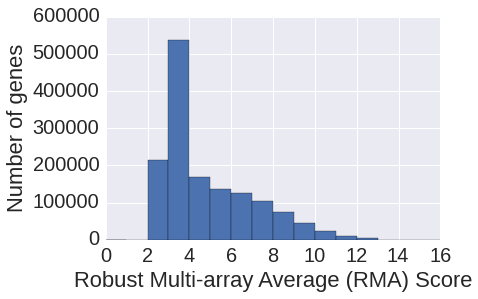

In [18]:
plt.hist(np.reshape(gex.values, (-1, )), range=(0, 16), bins=16)
plt.ylabel('Number of genes')
plt.xlabel('Robust Multi-array Average (RMA) Score')

### Normalize using mean for gene over all cell lines

In [19]:
gex.mean(axis=1).shape

(17419,)

In [20]:
gex_over_cells = gex.sub(gex.mean(axis=1), axis=0).div(gex.std(axis=1), axis=0)

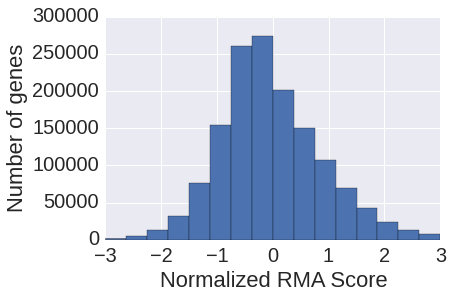

In [21]:
plt.hist(np.reshape(gex_over_cells.values, (-1, )), range=(-3, 3), bins=16)
plt.ylabel('Number of genes')
plt.xlabel('Normalized RMA Score')

### Normalize using mean for cell line over all genes

In [22]:
gex_over_genes = gex.sub(gex.mean(axis=0), axis=1).div(gex.std(axis=0), axis=1)

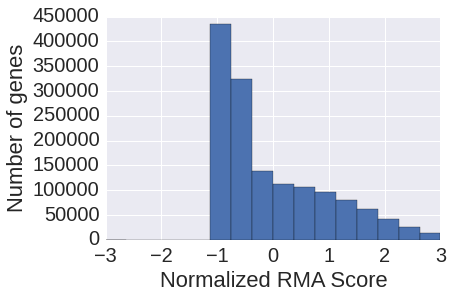

In [23]:
plt.hist(np.reshape(gex_over_genes.values, (-1, )), range=(-3, 3), bins=16)
plt.ylabel('Number of genes')
plt.xlabel('Normalized RMA Score')

# To database

In [24]:
gex.head()

,22RV1,647-V,A549,BFTC-905,BT-20,BT-474,BT-549,C32,CAL-120,CAL-148,CAL-51,CAMA-1,COLO-205,Calu-3,Calu-6,DMS-114,DU-4475,EVSA-T,HCC1143,HCC1187,HCC1395,HCC1419,HCC1428,HCC1500,HCC1569,HCC1806,HCC1937,HCC1954,HCC38,HCC70,HCT-116,HT-1197,HT-1376,HT-29,Hs-578-T,J82,KATOIII,KMS-11,KU-19-19,LS-513,M14,MCF7,MDA-MB-157,MDA-MB-231,MDA-MB-361,MDA-MB-415,MDA-MB-436,MDA-MB-453,MDA-MB-468,MFM-223,NCI-H1299,NCI-H1563,NCI-H1703,NCI-H1793,NCI-H1975,NCI-H2085,NCI-H2170,NCI-H2228,NCI-H226,NCI-H2291,NCI-H23,NCI-H3122,NCI-H358,NCI-H520,NCI-H522,NCI-H747,NCI-H838,NCI-SNU-16,RKO,RT4,SW48,SW620,SW780,SW837,SW900,SW948,T-24,T47D,TCCSUP,UACC-812,UM-UC-3,VCaP,VM-CUB-1
A1BG,3.530584,2.788878,5.351535,3.654691,3.413191,3.512673,5.503611,5.301429,6.208447,3.967330,5.506955,5.473663,3.659052,3.445720,3.250152,5.025810,3.712974,3.992799,6.653324,3.860001,3.818815,5.062066,4.943208,5.117451,4.651759,7.557265,4.012750,4.394033,4.314272,3.558035,3.231159,2.891782,2.996703,3.333250,5.696576,3.403658,3.765339,3.429940,4.146027,3.436224,4.331010,4.677871,5.633269,3.993322,3.239070,3.160667,5.675360,5.622213,3.251473,5.366995,4.410914,3.784122,5.742016,5.217647,4.617750,5.740719,3.213566,3.538686,3.534607,3.612600,3.906863,3.219004,3.779601,4.238043,4.313296,3.149603,4.420252,3.367825,2.733173,3.359233,3.604357,3.226869,3.085338,3.193601,3.562164,3.120944,3.030891,4.015417,3.386465,4.565087,4.806826,3.442403,3.233975
A1CF,6.364383,2.929860,5.899714,2.879513,2.960482,3.054495,3.107128,3.126334,2.981775,3.075956,2.872071,3.141034,7.210961,2.976691,3.359157,2.947547,2.932662,2.872890,2.809667,2.977178,2.972840,2.985650,2.949033,2.894628,2.962179,2.954737,2.815736,2.913561,2.984274,2.991716,2.957640,3.134189,2.931337,3.035997,2.885962,2.948641,2.972890,3.003220,3.076125,4.307525,2.903783,3.221482,3.235645,2.906964,2.973523,3.065818,2.934078,2.920719,2.909005,2.999021,3.057679,3.178817,3.016101,3.123458,2.994303,2.807124,2.962080,2.965398,2.904675,3.251876,3.131992,2.949988,2.931010,3.123205,3.109252,3.030174,2.933147,7.616778,3.176171,3.076448,3.049307,3.756048,2.833101,3.103560,2.996603,6.035482,3.190048,3.013487,3.177574,2.979775,3.159821,4.049642,3.038010
A2M,5.333116,3.163920,3.385313,3.145660,3.485672,3.374128,3.306887,11.194502,3.133883,3.252529,3.287678,3.553870,3.284050,3.125750,3.392565,3.335711,5.857938,3.371901,3.181255,3.101857,7.333633,3.529651,3.716710,3.443310,12.962624,3.102288,3.262667,3.431608,3.515306,3.548095,3.015057,3.274353,3.390316,3.433933,3.184189,4.248470,3.347285,3.531883,3.692506,3.914816,6.572986,3.502539,4.031836,3.280705,3.496711,3.194349,3.353889,3.585621,6.748265,5.349334,3.481793,3.520293,3.364239,3.264536,3.315750,3.352053,3.425817,3.317356,3.542737,3.271784,3.454828,3.257612,3.189635,3.322089,3.702488,3.320323,3.280496,3.234721,3.587857,3.414311,3.370937,3.423342,3.485978,3.328670,3.253735,3.424149,3.422091,3.435566,10.367402,4.068013,3.318134,3.669509,3.262412
A2ML1,2.907726,2.659589,2.876303,2.618580,3.203183,2.990600,2.750999,2.809603,2.652527,4.176452,3.946546,3.037501,2.830605,2.814887,3.217121,2.734617,2.810957,3.244767,2.882418,2.827790,3.094473,2.970912,3.219312,2.862272,2.984883,2.912465,3.026253,2.914855,2.912427,5.398271,2.747944,3.203564,2.863508,2.872562,2.850983,2.866479,2.935965,2.757120,3.052064,2.872895,2.756976,2.823238,2.994586,2.784113,2.957074,2.861270,2.845468,2.970381,3.038762,2.917099,2.868770,2.816616,2.961184,2.966420,2.875874,3.078362,3.027520,2.722523,2.815796,2.768303,2.855416,2.868177,2.907705,2.753796,2.896764,2.900725,2.714300,3.038924,2.735681,2.920353,3.211124,2.975449,2.791813,2.970275,2.844126,2.810739,3.005388,2.927293,2.841073,2.799085,2.848456,3.045514,2.848073
A3GALT2P,2.815383,2.949402,2.794812,3.051636,2.727538,3.046176,2.600750,2.772945,2.759164,2.973257,3.007847,2.813239,2.817318,2.906216,2.951504,2.867167,3.222096,2.758084,2.898673,2.949275,3.002633,3.039915,2.889149,2.794062,2.696788,2.841877,2.637763,2.627251,2.638571,2.585234,3.350766,2.676877,2.928732,2.911099,2.860962,2.682130,2.642

In [25]:
cell_lines = list(gex.columns)

In [26]:
gex_melted = (
    pd.melt(gex.reset_index().rename(columns={'index': 'gene'}), 
            id_vars=['gene'], value_vars=cell_lines)
    .rename(columns={'variable': 'cell_line', 'value': 'gene_expression'})
)

In [27]:
gex_melted.head()

,gene,cell_line,gene_expression
0,A1BG,22RV1,3.530584
1,A1CF,22RV1,6.364383
2,A2M,22RV1,5.333116
3,A2ML1,22RV1,2.907726
4,A3GALT2P,22RV1,2.815383


In [28]:
gex_over_cells_melted = (
    pd.melt(gex_over_cells.reset_index().rename(columns={'index': 'gene'}), 
            id_vars=['gene'], value_vars=cell_lines)
    .rename(columns={'variable': 'cell_line', 'value': 'gene_expression'})
)

In [29]:
gex_over_cells_melted.head()

,gene,cell_line,gene_expression
0,A1BG,22RV1,-0.599778
1,A1CF,22RV1,3.442345
2,A2M,22RV1,0.848609
3,A2ML1,22RV1,-0.148586
4,A3GALT2P,22RV1,-0.141800


In [30]:
gex_over_genes_melted = (
    pd.melt(gex_over_genes.reset_index().rename(columns={'index': 'gene'}), 
            id_vars=['gene'], value_vars=cell_lines)
    .rename(columns={'variable': 'cell_line', 'value': 'gene_expression'})
)

In [31]:
gex_over_genes_melted.head()

,gene,cell_line,gene_expression
0,A1BG,22RV1,-0.612827
1,A1CF,22RV1,0.718647
2,A2M,22RV1,0.234101
3,A2ML1,22RV1,-0.905480
4,A3GALT2P,22RV1,-0.948868


In [32]:
gex_melted_all = (
    gex_melted.rename(columns={'gene_expression': 'gex'})
    .merge(gex_over_cells_melted.rename(columns={'gene_expression': 'gex_over_cells'}), on=['gene', 'cell_line'])
    .merge(gex_over_genes_melted.rename(columns={'gene_expression': 'gex_over_genes'}), on=['gene', 'cell_line'])
)

In [33]:
gex_melted_all.head()

,gene,cell_line,gex,gex_over_cells,gex_over_genes
0,A1BG,22RV1,3.530584,-0.599778,-0.612827
1,A1CF,22RV1,6.364383,3.442345,0.718647
2,A2M,22RV1,5.333116,0.848609,0.234101
3,A2ML1,22RV1,2.907726,-0.148586,-0.905480
4,A3GALT2P,22RV1,2.815383,-0.141800,-0.948868


In [34]:
gex_melted_all.corr()

,gex,gex_over_cells,gex_over_genes
gex,1.000000,0.280881,0.999860
gex_over_cells,0.280881,1.000000,0.279263
gex_over_genes,0.999860,0.279263,1.000000


In [35]:
engine = sa.create_engine('mysql://strokach:@192.168.6.19:3306/az_dream_cell_features')
dtypes = {
    'gene': sa.VARCHAR(255),
    'cell_line': sa.VARCHAR(255),
    'gex': sa.dialects.mysql.DOUBLE,
    'gex_over_cells': sa.dialects.mysql.DOUBLE,
    'gex_over_genes': sa.dialects.mysql.DOUBLE,
}
gex_melted_all.to_sql('gex', engine, dtype=dtypes, index=False, if_exists='replace')

In [36]:
engine.execute('create index a on gex (gene, cell_line)')
engine.execute('create index b on gex (cell_line, gene)')

# Correlation across drug pairs

In [159]:
engine = sa.create_engine('mysql://strokach:@192.168.6.19:3306/az_dream')
drug_to_target = pd.read_sql_table('drug_to_target', engine)

In [161]:
drug_to_target.head(2)

,drug,target_original,target,hgnc_name,hgnc_acc,hgnc_description,ensg,enst,ensp,ensp_idx
0,ADAM17,ADAM17,ADAM17,ADAM17,HGNC:195,ADAM metallopeptidase domain 17,ENSG00000151694,ENST00000310823,ENSP00000309968,309968
1,ADAM17,ADAM17,ADAM17,ADAM17,HGNC:195,ADAM metallopeptidase domain 17,ENSG00000151694,ENST00000497134,ENSP00000418728,418728


In [186]:
drug_to_target_to_cell = (
    drug_to_target.rename(columns={'hgnc_name': 'gene'})[['drug', 'gene']]
    .merge(gex_melted_all, on=['gene'])
)

In [187]:
drug_to_target_to_cell.head()

,drug,gene,cell_line,gex,gex_over_cells,gex_over_genes
0,ADAM17,ADAM17,22RV1,4.249165,-1.250541,-0.275199
1,ADAM17,ADAM17,647-V,4.260769,-1.226349,-0.253263
2,ADAM17,ADAM17,A549,5.509065,1.376034,0.312947
3,ADAM17,ADAM17,BFTC-905,5.166420,0.661706,0.145675
4,ADAM17,ADAM17,BT-20,5.182499,0.695226,0.161445


In [188]:
drug_to_cell = (
    drug_to_target_2.groupby(['drug', 'cell_line'])
    [['gex', 'gex_over_cells', 'gex_over_genes']]
    .agg(np.mean)
    .reset_index()
)

In [190]:
drug_to_cell.head()

,drug,cell_line,gex,gex_over_cells,gex_over_genes
0,ADAM17,22RV1,4.249165,-1.250541,-0.275199
1,ADAM17,647-V,4.260769,-1.226349,-0.253263
2,ADAM17,A549,5.509065,1.376034,0.312947
3,ADAM17,BFTC-905,5.166420,0.661706,0.145675
4,ADAM17,BT-20,5.182499,0.695226,0.161445


In [195]:
drug_to_gex = df.pivot(index='drug', columns='cell_line', values='gex').T.corr()

In [196]:
drug_to_gex_over_cells = df.pivot(index='drug', columns='cell_line', values='gex_over_cells').T.corr()

In [197]:
drug_to_gex_over_genes = df.pivot(index='drug', columns='cell_line', values='gex_over_genes').T.corr()

In [231]:
drug_corr_gex = (
    matrix_to_values(drug_to_gex)
    .rename(columns={'name_1': 'drug_1', 'name_2': 'drug_2', 'value': 'gex'})
)
assert all(drug_corr_gex['drug_1'] < drug_corr_gex['drug_2'])

In [232]:
drug_corr_gex_over_cells = (
    matrix_to_values(drug_to_gex_over_cells)
    .rename(columns={'name_1': 'drug_1', 'name_2': 'drug_2', 'value': 'gex_over_cells'})
)
assert all(drug_corr_gex_over_cells['drug_1'] < drug_corr_gex_over_cells['drug_2'])

In [233]:
drug_corr_gex_over_genes = (
    matrix_to_values(drug_to_gex_over_genes)
    .rename(columns={'name_1': 'drug_1', 'name_2': 'drug_2', 'value': 'gex_over_genes'})
)
assert all(drug_corr_gex_over_genes['drug_1'] < drug_corr_gex_over_genes['drug_2'])

In [234]:
drug_corr_all = (
    drug_corr_gex
    .merge(drug_corr_gex_over_cells, on=['drug_1', 'drug_2'])
    .merge(drug_corr_gex_over_genes, on=['drug_1', 'drug_2'])
)

In [235]:
drug_corr_all['unique_id'] = (
    drug_corr_all['drug_1'] + '.' + 
    drug_corr_all['drug_2']
)

In [236]:
drug_corr_all.head()

,drug_1,drug_2,gex,gex_over_cells,gex_over_genes,unique_id
0,ADAM17,AKT,-0.226604,-0.325814,-0.181756,ADAM17.AKT
1,ADAM17,AKT_1,-0.278594,-0.353025,-0.228053,ADAM17.AKT_1
2,ADAM17,AKT_PIK3C,-0.232840,-0.304710,-0.194538,ADAM17.AKT_PIK3C
3,ADAM17,AKT_SGK,0.071297,-0.329491,0.102825,ADAM17.AKT_SGK
4,ADAM17,ALK,0.102961,0.102961,0.128368,ADAM17.ALK


## Test with synergy scores

In [212]:
training_data_by_drugpair = pd.read_sql_table('training_data_by_drugpair', engine)

In [213]:
training_data_by_drugpair.head()

,COMBINATION_ID,len,mean,mean_unweighted,std,std_unweighted,sum_weight,ste,log_ste,norm_log_ste,confidence
0,ADAM17.AKT,14,9.506099,5.005206,18.090624,23.066728,10.200,4.834923,1.575865,0.374404,0.625596
1,ADAM17.BCL2_BCL2L1,12,-3.439654,-4.554570,5.543807,6.539051,11.050,1.600359,0.470228,0.000522,0.999478
2,ADAM17.FGFR,13,-4.934241,-8.917044,17.415001,20.848170,10.150,4.830052,1.574857,0.374063,0.625937
3,ADAM17.MAP2K_1,13,-1.658434,-6.053760,16.004816,18.690474,11.100,4.438937,1.490415,0.345508,0.654492
4,ADAM17.MTOR_1,14,9.511901,9.625085,17.444983,15.960108,10.151,4.662368,1.539523,0.362115,0.637885


In [214]:
columns = [
    'unique_id', 'synergy_score_mean', 'synergy_score_std', 'synergy_score_ste', 
    'synergy_score_confidence'
]
synergy_score = (
    training_data_by_drugpair.rename(
        columns={
            'COMBINATION_ID': 'unique_id',
            'mean': 'synergy_score_mean',
            'std': 'synergy_score_std',
            'ste': 'synergy_score_ste',
            'confidence': 'synergy_score_confidence'
        })
    [columns]
)
synergy_score.head()

,unique_id,synergy_score_mean,synergy_score_std,synergy_score_ste,synergy_score_confidence
0,ADAM17.AKT,9.506099,18.090624,4.834923,0.625596
1,ADAM17.BCL2_BCL2L1,-3.439654,5.543807,1.600359,0.999478
2,ADAM17.FGFR,-4.934241,17.415001,4.830052,0.625937
3,ADAM17.MAP2K_1,-1.658434,16.004816,4.438937,0.654492
4,ADAM17.MTOR_1,9.511901,17.444983,4.662368,0.637885


### Merge

In [237]:
synergy_score_wgex = (
    synergy_score
    .merge(drug_corr_all, on=['unique_id'])
)

In [239]:
synergy_score_wgex.corr()[['gex', 'gex_over_cells', 'gex_over_genes']]

,gex,gex_over_cells,gex_over_genes
synergy_score_mean,0.012727,-0.037027,0.020847
synergy_score_std,-0.083579,-0.097265,-0.074338
synergy_score_ste,-0.111739,-0.120958,-0.096977
synergy_score_confidence,0.123014,0.117548,0.107666
gex,1.000000,0.906233,0.994611
gex_over_cells,0.906233,1.000000,0.898563
gex_over_genes,0.994611,0.898563,1.000000


# Correlation across cell line + drug pairs

In [38]:
engine = sa.create_engine('mysql://strokach:@192.168.6.19:3306/az_dream')
drug_pair_to_gene_pair = pd.read_sql_table('drug_pair_to_gene_pair', engine)
all_cell_line_drug_pairs = pd.read_sql_table('all_cell_line_drug_pairs', engine)

In [39]:
gene_set = set(drug_pair_to_gene_pair['gene_1']) | set(drug_pair_to_gene_pair['gene_2'])

In [51]:
all_cell_line_drug_pairs.head()

,CELL_LINE_UNIQUE_ID,CELL_LINE,COMPOUND_A,COMPOUND_B
0,BT-20.ADAM17.AKT,BT-20,ADAM17,AKT
1,BT-20.ADAM17.AKT_1,BT-20,ADAM17,AKT_1
2,BT-20.ADAM17.AKT_PIK3C,BT-20,ADAM17,AKT_PIK3C
3,BT-20.ADAM17.AKT_SGK,BT-20,ADAM17,AKT_SGK
4,BT-20.ADAM17.ALK,BT-20,ADAM17,ALK


In [47]:
drug_pair_to_gene_pair.head()

,UNIQUE_ID,COMPOUND_A,COMPOUND_B,gene_1,gene_2,gene_pair
0,ADAM17.AKT,ADAM17,AKT,ADAM17,AKT1,"ADAM17,AKT1"
1,ADAM17.AKT,ADAM17,AKT,ADAM17,AKT2,"ADAM17,AKT2"
2,ADAM17.AKT,ADAM17,AKT,ADAM17,AKT3,"ADAM17,AKT3"
3,ADAM17.AKT_1,ADAM17,AKT_1,ADAM17,AKT1,"ADAM17,AKT1"
4,ADAM17.AKT_1,ADAM17,AKT_1,ADAM17,AKT1S1,"ADAM17,AKT1S1"


In [56]:
gex_melted_all.head()

,gene,cell_line,gex,gex_over_cells,gex_over_genes
0,A1BG,22RV1,3.530584,-0.599778,-0.612827
1,A1CF,22RV1,6.364383,3.442345,0.718647
2,A2M,22RV1,5.333116,0.848609,0.234101
3,A2ML1,22RV1,2.907726,-0.148586,-0.905480
4,A3GALT2P,22RV1,2.815383,-0.141800,-0.948868


In [ ]:
cell_line_drug_pair_gex = (
    all_cell_line_drug_pairs
    .merge(drug_pair_to_gene_pair, on=['COMPOUND_A', 'COMPOUND_B'])
    .merge(gex_melted_all
               .rename(columns={'cell_line': 'CELL_LINE', 'gene': 'gene_1'}), 
           on=['CELL_LINE', 'gene_1'])
    .merge(gex_melted_all
               .rename(columns={'cell_line': 'CELL_LINE', 'gene': 'gene_2'}),
           on=['CELL_LINE', 'gene_2'], suffixes=('_1', '_2'))
)

In [64]:
cell_line_drug_pair_gex['gex_mean'] = (
    (cell_line_drug_pair_gex['gex_1'] + cell_line_drug_pair_gex['gex_2']) / 2
)
cell_line_drug_pair_gex['gex_over_cells_mean'] = (
    (cell_line_drug_pair_gex['gex_over_cells_1'] + cell_line_drug_pair_gex['gex_over_cells_2']) / 2
)
cell_line_drug_pair_gex['gex_over_genes_mean'] = (
    (cell_line_drug_pair_gex['gex_over_genes_1'] + cell_line_drug_pair_gex['gex_over_genes_2']) / 2
)

In [62]:
cell_line_drug_pair_gex['gex_diff'] = (
    (cell_line_drug_pair_gex['gex_1'] - cell_line_drug_pair_gex['gex_2']).apply(abs)
)
cell_line_drug_pair_gex['gex_over_cells_diff'] = (
    (cell_line_drug_pair_gex['gex_over_cells_1'] - cell_line_drug_pair_gex['gex_over_cells_2']).abs()
)
cell_line_drug_pair_gex['gex_over_genes_diff'] = (
    (cell_line_drug_pair_gex['gex_over_genes_1'] - cell_line_drug_pair_gex['gex_over_genes_2']).abs()
)

In [65]:
cell_line_drug_pair_gex.head()

,CELL_LINE_UNIQUE_ID,CELL_LINE,COMPOUND_A,COMPOUND_B,UNIQUE_ID,gene_1,gene_2,gene_pair,gex_1,gex_over_cells_1,gex_over_genes_1,gex_2,gex_over_cells_2,gex_over_genes_2,gex_diff,gex_over_cells_diff,gex_over_genes_diff,gex_mean,gex_over_cells_mean,gex_over_genes_mean
0,BT-20.ADAM17.AKT,BT-20,ADAM17,AKT,ADAM17.AKT,ADAM17,AKT1,"ADAM17,AKT1",5.182499,0.695226,0.161445,4.555038,-0.317165,-0.129186,0.627461,1.012392,0.290631,4.868769,0.189031,0.01613
1,BT-20.ADAM17.AKT_1,BT-20,ADAM17,AKT_1,ADAM17.AKT_1,ADAM17,AKT1,"ADAM17,AKT1",5.182499,0.695226,0.161445,4.555038,-0.317165,-0.129186,0.627461,1.012392,0.290631,4.868769,0.189031,0.01613
2,BT-20.ADAM17.AKT_PIK3C,BT-20,ADAM17,AKT_PIK3C,ADAM17.AKT_PIK3C,ADAM17,AKT1,"ADAM17,AKT1",5.182499,0.695226,0.161445,4.555038,-0.317165,-0.129186,0.627461,1.012392,0.290631,4.868769,0.189031,0.01613
3,BT-20.ADAM17.AKT_SGK,BT-20,ADAM17,AKT_SGK,ADAM17.AKT_SGK,ADAM17,AKT1,"ADAM17,AKT1",5.182499,0.695226,0.161445,4.555038,-0.317165,-0.129186,0.627461,1.012392,0.290631,4.868769,0.189031,0.01613
4,BT-20.ADAM17.Carboplatin,BT-20,ADAM17,Carboplatin,ADAM17.Carboplatin,ADAM17,AKT1,"ADAM17,AKT1",5.182499,0.695226,0.161445,4.555038,-0.317165,-0.129186,0.627461,1.012392,0.290631,4.868769,0.189031,0.01613


In [67]:
columns = [
    'gex_mean', 'gex_over_cells_mean', 'gex_over_genes_mean',
    'gex_diff', 'gex_over_cells_diff', 'gex_over_genes_diff',
]

In [69]:
cell_line_drug_pair_gex_gp = cell_line_drug_pair_gex.groupby(['CELL_LINE_UNIQUE_ID', 'UNIQUE_ID'])

In [70]:
cell_line_drug_pair_gex_gp_subset = cell_line_drug_pair_gex_gp[columns]

In [73]:
df = cell_line_drug_pair_gex_gp_subset.agg([np.mean, np.std])

In [104]:
df2 = df.reset_index()

In [105]:
df2.columns = [x[0] if not x[1] or x[1] == 'mean' else '_'.join(x) for x in df2.columns.values]

In [106]:
df2.head()

,CELL_LINE_UNIQUE_ID,UNIQUE_ID,gex_mean,gex_mean_std,gex_over_cells_mean,gex_over_cells_mean_std,gex_over_genes_mean,gex_over_genes_mean_std,gex_diff,gex_diff_std,gex_over_cells_diff,gex_over_cells_diff_std,gex_over_genes_diff,gex_over_genes_diff_std
0,22RV1.ADAM17.AKT,ADAM17.AKT,3.983331,0.419430,-0.852319,0.170910,-0.400102,0.197071,0.761661,0.507447,0.796444,0.341820,0.357870,0.238427
1,22RV1.ADAM17.AKT_1,ADAM17.AKT_1,4.033532,0.355844,-0.527693,0.473387,-0.376515,0.167195,0.665423,0.430701,1.445695,0.946775,0.312652,0.202367
2,22RV1.ADAM17.AKT_PIK3C,ADAM17.AKT_PIK3C,4.276006,0.717799,-0.727756,0.410221,-0.262587,0.337261,1.050359,0.932132,1.062747,0.796171,0.493516,0.437967
3,22RV1.ADAM17.AKT_SGK,ADAM17.AKT_SGK,3.996116,0.290212,-0.657144,0.437626,-0.394095,0.136357,0.652446,0.378311,1.186793,0.875253,0.306555,0.177751
4,22RV1.ADAM17.ALK,ADAM17.ALK,3.772558,NaN,-0.564248,NaN,-0.499135,NaN,0.953215,NaN,1.372586,NaN,0.447872,NaN


## Test with synergy scores

In [130]:
training_data = pd.read_sql_table('training_data', engine)

In [138]:
training_data['CELL_LINE_UNIQUE_ID'] = training_data['CELL_LINE'] + '.' + training_data['COMBINATION_ID']
training_data_2 = training_data[training_data['QA'] == 1]
training_data_3 = (
    training_data_2[['CELL_LINE_UNIQUE_ID', 'SYNERGY_SCORE']]
    .merge(df2, on=['CELL_LINE_UNIQUE_ID'])
)

In [142]:
training_data_3.corr()['SYNERGY_SCORE'].sort_values(ascending=False)

SYNERGY_SCORE              1.000000
gex_over_cells_diff        0.080109
gex_diff                   0.066158
gex_over_genes_diff        0.065961
gex_diff_std               0.048701
gex_over_genes_diff_std    0.048438
gex_over_cells_mean        0.035071
gex_over_cells_diff_std    0.034728
gex_mean_std               0.031343
gex_over_genes_mean_std    0.031042
gex_over_cells_mean_std    0.030911
gex_mean                   0.029497
gex_over_genes_mean        0.029469
Name: SYNERGY_SCORE, dtype: float64

In [ ]:
training_data_2 = (
    training_data
    .merge(df2.rename())
)

In [240]:
gex.head()

,22RV1,647-V,A549,BFTC-905,BT-20,BT-474,BT-549,C32,CAL-120,CAL-148,CAL-51,CAMA-1,COLO-205,Calu-3,Calu-6,DMS-114,DU-4475,EVSA-T,HCC1143,HCC1187,HCC1395,HCC1419,HCC1428,HCC1500,HCC1569,HCC1806,HCC1937,HCC1954,HCC38,HCC70,HCT-116,HT-1197,HT-1376,HT-29,Hs-578-T,J82,KATOIII,KMS-11,KU-19-19,LS-513,M14,MCF7,MDA-MB-157,MDA-MB-231,MDA-MB-361,MDA-MB-415,MDA-MB-436,MDA-MB-453,MDA-MB-468,MFM-223,NCI-H1299,NCI-H1563,NCI-H1703,NCI-H1793,NCI-H1975,NCI-H2085,NCI-H2170,NCI-H2228,NCI-H226,NCI-H2291,NCI-H23,NCI-H3122,NCI-H358,NCI-H520,NCI-H522,NCI-H747,NCI-H838,NCI-SNU-16,RKO,RT4,SW48,SW620,SW780,SW837,SW900,SW948,T-24,T47D,TCCSUP,UACC-812,UM-UC-3,VCaP,VM-CUB-1
A1BG,3.530584,2.788878,5.351535,3.654691,3.413191,3.512673,5.503611,5.301429,6.208447,3.967330,5.506955,5.473663,3.659052,3.445720,3.250152,5.025810,3.712974,3.992799,6.653324,3.860001,3.818815,5.062066,4.943208,5.117451,4.651759,7.557265,4.012750,4.394033,4.314272,3.558035,3.231159,2.891782,2.996703,3.333250,5.696576,3.403658,3.765339,3.429940,4.146027,3.436224,4.331010,4.677871,5.633269,3.993322,3.239070,3.160667,5.675360,5.622213,3.251473,5.366995,4.410914,3.784122,5.742016,5.217647,4.617750,5.740719,3.213566,3.538686,3.534607,3.612600,3.906863,3.219004,3.779601,4.238043,4.313296,3.149603,4.420252,3.367825,2.733173,3.359233,3.604357,3.226869,3.085338,3.193601,3.562164,3.120944,3.030891,4.015417,3.386465,4.565087,4.806826,3.442403,3.233975
A1CF,6.364383,2.929860,5.899714,2.879513,2.960482,3.054495,3.107128,3.126334,2.981775,3.075956,2.872071,3.141034,7.210961,2.976691,3.359157,2.947547,2.932662,2.872890,2.809667,2.977178,2.972840,2.985650,2.949033,2.894628,2.962179,2.954737,2.815736,2.913561,2.984274,2.991716,2.957640,3.134189,2.931337,3.035997,2.885962,2.948641,2.972890,3.003220,3.076125,4.307525,2.903783,3.221482,3.235645,2.906964,2.973523,3.065818,2.934078,2.920719,2.909005,2.999021,3.057679,3.178817,3.016101,3.123458,2.994303,2.807124,2.962080,2.965398,2.904675,3.251876,3.131992,2.949988,2.931010,3.123205,3.109252,3.030174,2.933147,7.616778,3.176171,3.076448,3.049307,3.756048,2.833101,3.103560,2.996603,6.035482,3.190048,3.013487,3.177574,2.979775,3.159821,4.049642,3.038010
A2M,5.333116,3.163920,3.385313,3.145660,3.485672,3.374128,3.306887,11.194502,3.133883,3.252529,3.287678,3.553870,3.284050,3.125750,3.392565,3.335711,5.857938,3.371901,3.181255,3.101857,7.333633,3.529651,3.716710,3.443310,12.962624,3.102288,3.262667,3.431608,3.515306,3.548095,3.015057,3.274353,3.390316,3.433933,3.184189,4.248470,3.347285,3.531883,3.692506,3.914816,6.572986,3.502539,4.031836,3.280705,3.496711,3.194349,3.353889,3.585621,6.748265,5.349334,3.481793,3.520293,3.364239,3.264536,3.315750,3.352053,3.425817,3.317356,3.542737,3.271784,3.454828,3.257612,3.189635,3.322089,3.702488,3.320323,3.280496,3.234721,3.587857,3.414311,3.370937,3.423342,3.485978,3.328670,3.253735,3.424149,3.422091,3.435566,10.367402,4.068013,3.318134,3.669509,3.262412
A2ML1,2.907726,2.659589,2.876303,2.618580,3.203183,2.990600,2.750999,2.809603,2.652527,4.176452,3.946546,3.037501,2.830605,2.814887,3.217121,2.734617,2.810957,3.244767,2.882418,2.827790,3.094473,2.970912,3.219312,2.862272,2.984883,2.912465,3.026253,2.914855,2.912427,5.398271,2.747944,3.203564,2.863508,2.872562,2.850983,2.866479,2.935965,2.757120,3.052064,2.872895,2.756976,2.823238,2.994586,2.784113,2.957074,2.861270,2.845468,2.970381,3.038762,2.917099,2.868770,2.816616,2.961184,2.966420,2.875874,3.078362,3.027520,2.722523,2.815796,2.768303,2.855416,2.868177,2.907705,2.753796,2.896764,2.900725,2.714300,3.038924,2.735681,2.920353,3.211124,2.975449,2.791813,2.970275,2.844126,2.810739,3.005388,2.927293,2.841073,2.799085,2.848456,3.045514,2.848073
A3GALT2P,2.815383,2.949402,2.794812,3.051636,2.727538,3.046176,2.600750,2.772945,2.759164,2.973257,3.007847,2.813239,2.817318,2.906216,2.951504,2.867167,3.222096,2.758084,2.898673,2.949275,3.002633,3.039915,2.889149,2.794062,2.696788,2.841877,2.637763,2.627251,2.638571,2.585234,3.350766,2.676877,2.928732,2.911099,2.860962,2.682130,2.642

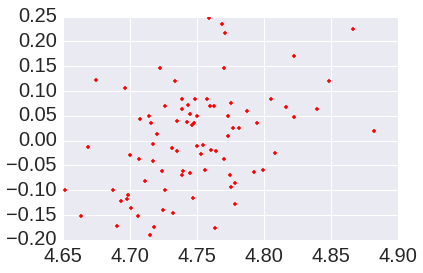

In [255]:
plt.plot(gex[1:1000].mean(), gex_over_cells[1:1000].mean(), 'r.')

In [ ]:
ex.loc[:3]

# Correlations

### Correlation in GEX scores

In [178]:
def matrix_to_values(df):
    """
    Convert a dataframe produced by `.corr()` to (name_1, name_2, value) format.
    """
    df.sort_index(axis=0, inplace=True)
    df.sort_index(axis=1, inplace=True)
    idx = np.triu_indices_from(df.values, 1)
    df_2 = pd.DataFrame({
        'name_1': df.index[idx[0]],
        'name_2': df.columns[idx[1]],
        'value': df.values[idx]})
    assert all(df_2['name_1'] < df_2['name_2'])
    return df_2

In [ ]:
cell_corr = gex.corr()

In [ ]:
cell_corr_2 = gex_over_cells.corr()

In [ ]:
cell_corr_1_df = matrix_to_values(cell_corr)

In [ ]:
cell_corr_2_df = matrix_to_values(cell_corr_2)

In [ ]:
cell_corr_df = cell_corr_1_df.merge(cell_corr_2_df, on=['name_1', 'name_2'], suffixes=('_1', '_2'))

In [ ]:
cell_corr_df.rename(
    columns={'name_1': 'cell_1', 
             'name_2': 'cell_2', 
             'value_1': 'pearson_r', 
             'value_2': 'pearson_r_corrected'},
    inplace=True)

In [ ]:
cell_corr_df.head()

In [ ]:
cell_corr_df.corr()

In [ ]:
cell_corr_df.shape

In [ ]:
83 * 82 // 2  # we are missing two cell lines

In [ ]:
engine = sa.create_engine('mysql://strokach:@192.168.6.19:3306/az_dream_cell_features')
cell_corr_df.to_sql('cell_expression_r', engine)
engine.execute('create index a on cell_expression_r (cell_1(255), cell_2(255))')
engine.execute('create index b on cell_expression_r (cell_2(255), cell_1(255))')

### Correlation in normalized GEX scores

In [ ]:
gene_corr = gex.T.corr()

In [ ]:
gene_corr_2 = gex_over_genes.T.corr()

In [ ]:
gene_corr_1_df = matrix_to_values(gene_corr)

In [ ]:
gene_corr_2_df = matrix_to_values(gene_corr_2)

In [ ]:
gene_corr_df = gene_corr_1_df.merge(gene_corr_2_df, on=['name_1', 'name_2'], suffixes=('_1', '_2'))

In [ ]:
gene_corr_df.rename(
    columns={'name_1': 'gene_1',
             'name_2': 'gene_2',
             'value_1': 'pearson_r',
             'value_2': 'pearson_r_corrected'},
    inplace=True)

In [ ]:
gene_corr_df.head()

In [ ]:
gene_corr_df.corr()

In [ ]:
engine = sa.create_engine('mysql://strokach:@192.168.6.19:3306/az_dream_target_features')
dtypes = {
    'gene_1': sa.VARCHAR(255),
    'gene_2': sa.VARCHAR(255),
    'pearson_r': sa.dialects.mysql.DOUBLE,
    'pearson_r_corrected': sa.dialects.mysql.DOUBLE,
}
gene_corr_df.to_sql('gene_expression_r', engine, dtype=dtypes, if_exists='replace', index=False)
engine.execute('create index a on gene_expression_r (gene_1(255), gene_2(255))')
engine.execute('create index b on gene_expression_r (gene_2(255), gene_1(255))')